In [3]:
%pip install textblob

   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 624.3/624.3 kB 7.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Cargar los datos
df = pd.read_csv(r"C:\Users\ShePlay\Desktop\nuri_tiktok_dataset.csv")

# Mostrar información básica
print(df.info())
print(df.describe())

# Convertir fechas a formato datetime
df['FECHA_PUBLICACION_FULL'] = pd.to_datetime(df['FECHA_PUBLICACION_FULL'])
df['FECHA'] = pd.to_datetime(df['FECHA'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ShePlay\AppData\Roaming\nltk_data...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TITULO_FULL             71 non-null     object 
 1   TITULO_LIMPIO           70 non-null     object 
 2   ENLACE                  74 non-null     object 
 3   FECHA_PUBLICACION_FULL  74 non-null     object 
 4   FECHA                   74 non-null     object 
 5   HORA                    74 non-null     object 
 6   VISUALIZACIONES         74 non-null     int64  
 7   ME_GUSTA                74 non-null     int64  
 8   PORCENTAJE_LIKES        74 non-null     float64
 9   COMENTARIOS             74 non-null     int64  
 10  COMPARTIDOS             74 non-null     int64  
 11  FAVORITOS               74 non-null     int64  
 12  PORCENTAJE_FAVORITOS    74 non-null     float64
dtypes: float64(2), int64(5), object(6)
memory usage: 7.6+ KB
None
       VISUALIZACIONES     ME_GUSTA

In [11]:
# Configuración de estilo
plt.style.use('seaborn-v0_8')  # Usar la versión compatible de seaborn
# Alternativas válidas: 'ggplot', 'fivethirtyeight', 'dark_background', etc.
# Puedes ver todos los estilos disponibles con: print(plt.style.available)

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

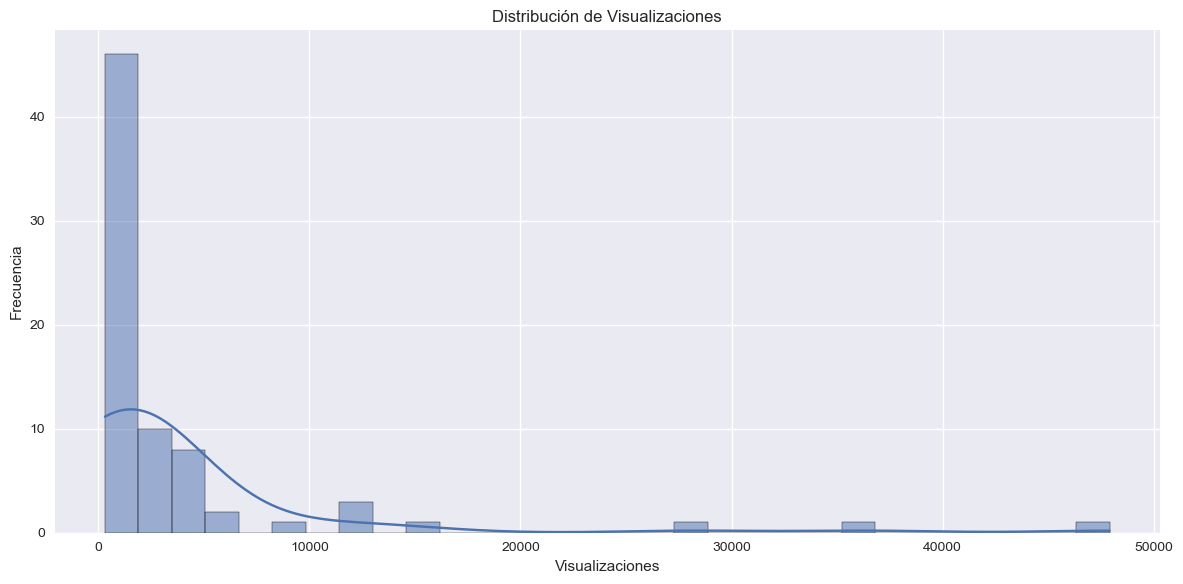

In [13]:
# 1. Distribución de visualizaciones
plt.figure()
sns.histplot(df['VISUALIZACIONES'], bins=30, kde=True)
plt.title('Distribución de Visualizaciones')
plt.xlabel('Visualizaciones')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

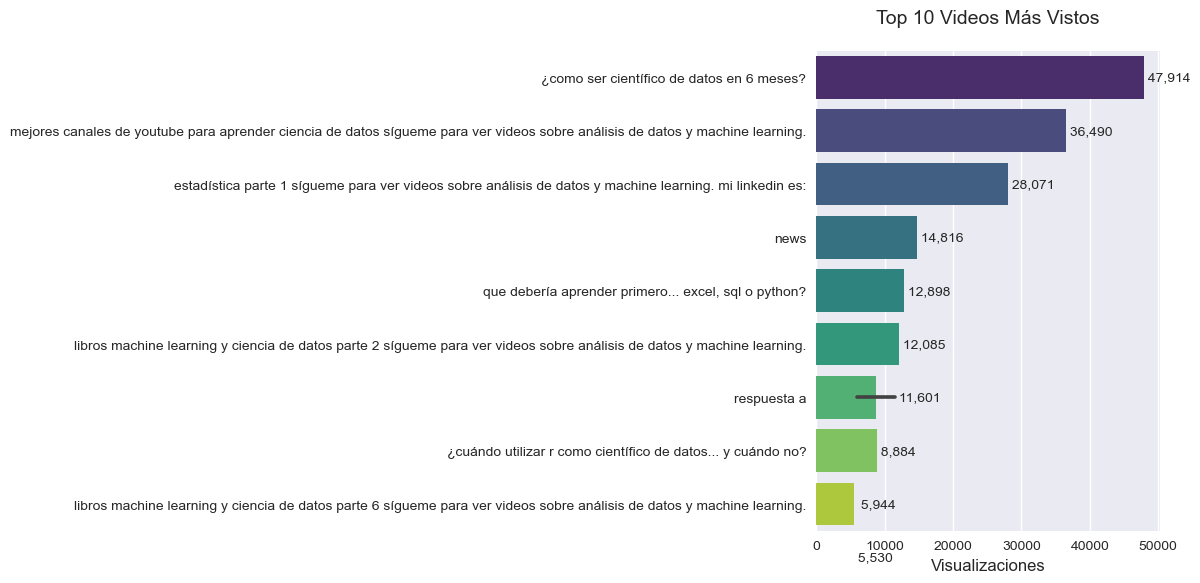

In [17]:
# 2. Top 10 videos más vistos
top_10 = df.sort_values('VISUALIZACIONES', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='VISUALIZACIONES', 
            y='TITULO_LIMPIO', 
            data=top_10, 
            hue='TITULO_LIMPIO',  # Asignamos hue para usar la paleta correctamente
            palette='viridis',
            dodge=False,          # Evita separación de barras
            legend=False)         # Oculta la leyenda redundante

plt.title('Top 10 Videos Más Vistos', fontsize=14, pad=20)
plt.xlabel('Visualizaciones', fontsize=12)
plt.ylabel('')  # Eliminamos el label del eje Y para ahorrar espacio
plt.tight_layout()

# Añadir los valores de visualizaciones en las barras
for i, value in enumerate(top_10['VISUALIZACIONES']):
    plt.text(value, i, f' {value:,}', va='center', fontsize=10)

plt.show()

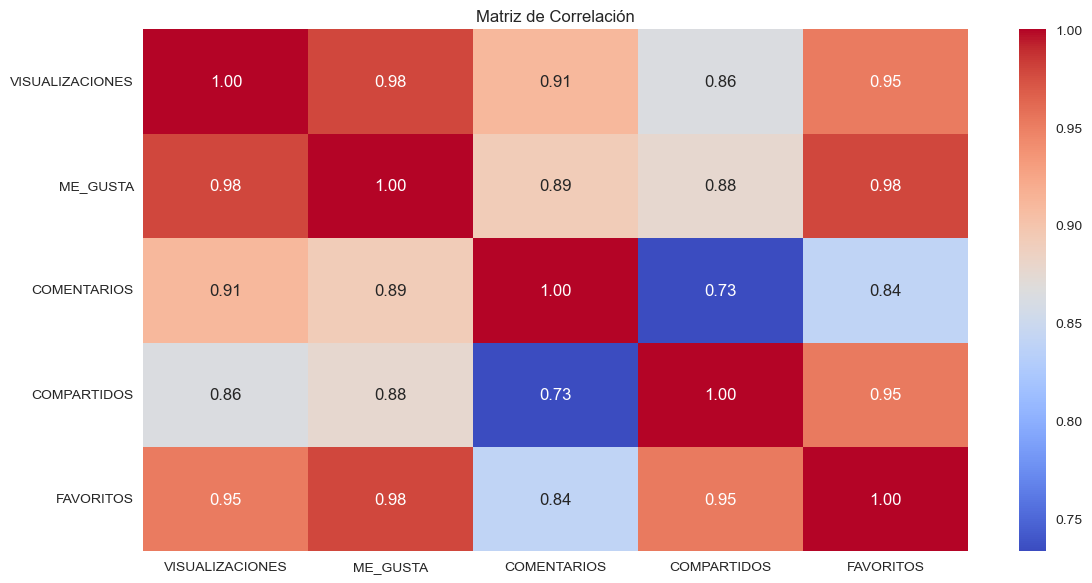

In [19]:
# 3. Correlación entre métricas
corr_matrix = df[['VISUALIZACIONES', 'ME_GUSTA', 'COMENTARIOS', 'COMPARTIDOS', 'FAVORITOS']].corr()
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

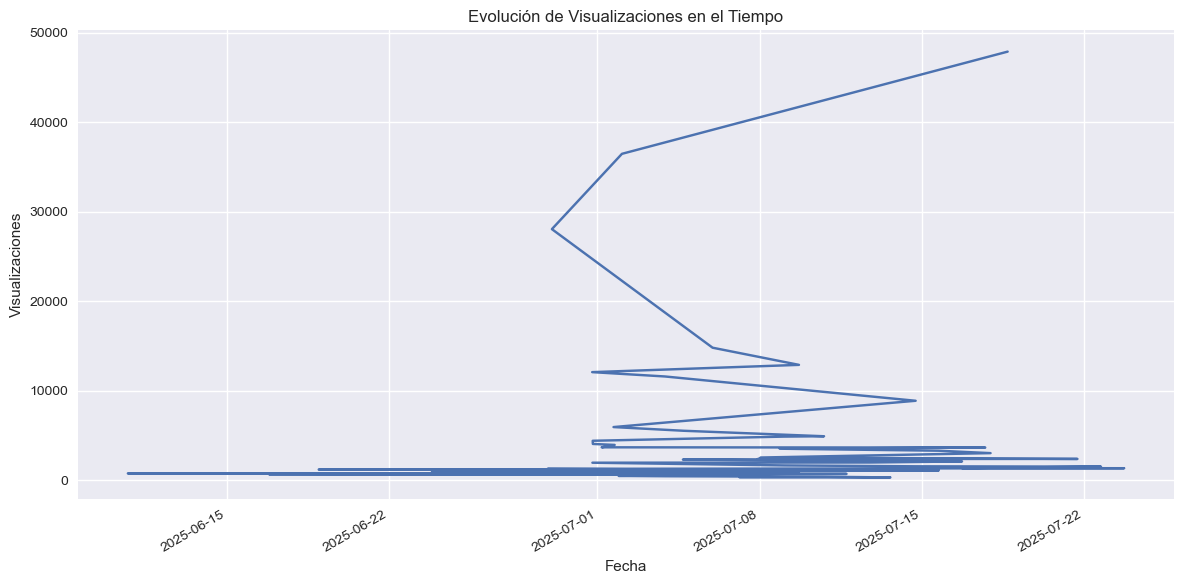

In [21]:
# 4. Evolución de visualizaciones en el tiempo
plt.figure()
df.set_index('FECHA_PUBLICACION_FULL')['VISUALIZACIONES'].plot()
plt.title('Evolución de Visualizaciones en el Tiempo')
plt.ylabel('Visualizaciones')
plt.xlabel('Fecha')
plt.grid(True)
plt.tight_layout()
plt.show()

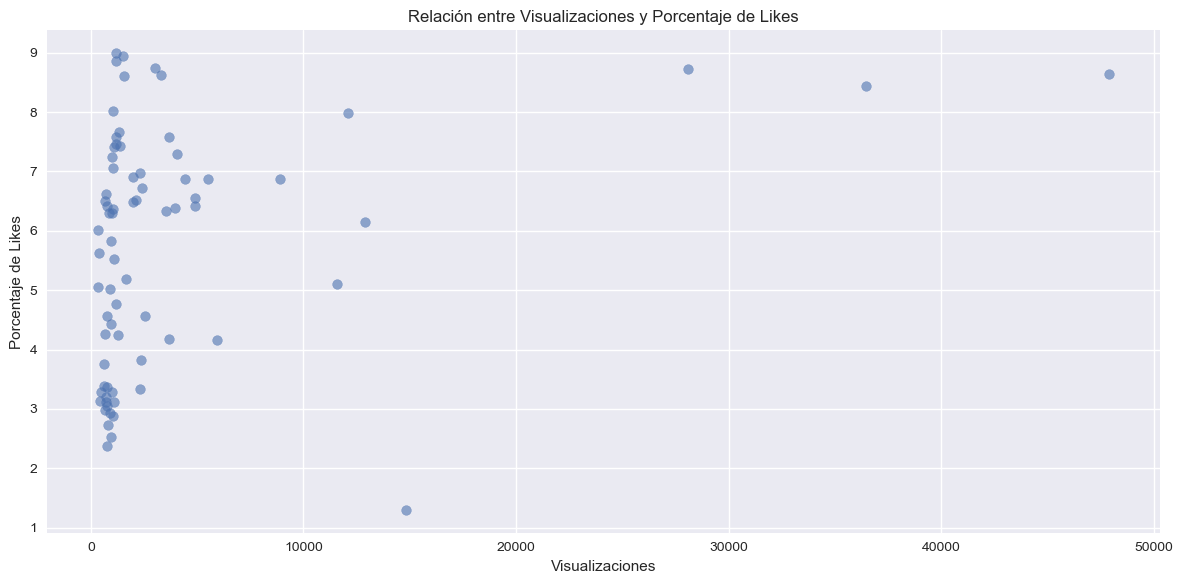

In [23]:
# 5. Porcentaje de likes vs visualizaciones
plt.figure()
plt.scatter(df['VISUALIZACIONES'], df['PORCENTAJE_LIKES'], alpha=0.6)
plt.title('Relación entre Visualizaciones y Porcentaje de Likes')
plt.xlabel('Visualizaciones')
plt.ylabel('Porcentaje de Likes')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

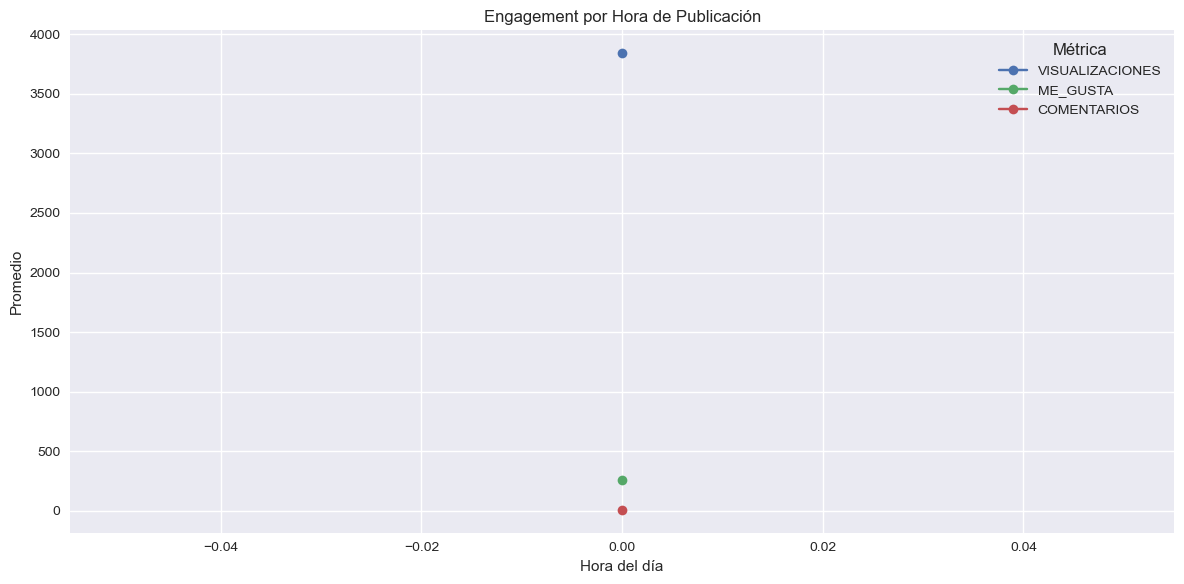

In [25]:
# 6. Hora de publicación vs engagement
df['HORA'] = pd.to_datetime(df['HORA']).dt.hour
engagement_by_hour = df.groupby('HORA')[['VISUALIZACIONES', 'ME_GUSTA', 'COMENTARIOS']].mean()
plt.figure()
engagement_by_hour.plot(marker='o')
plt.title('Engagement por Hora de Publicación')
plt.ylabel('Promedio')
plt.xlabel('Hora del día')
plt.grid(True)
plt.legend(title='Métrica')
plt.tight_layout()
plt.show()

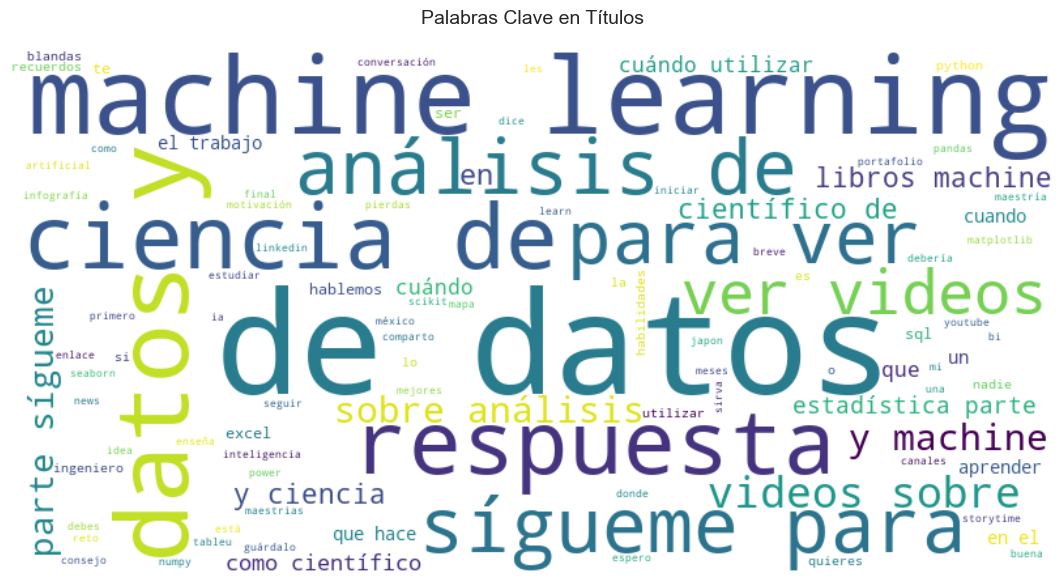

In [31]:
from collections import Counter
from wordcloud import WordCloud

# 1. Word Cloud de títulos (corregido para manejar NaN)
plt.figure(figsize=(12, 6))

# Filtrar NaN y unir títulos
all_titles = ' '.join(df['TITULO_LIMPIO'].dropna().astype(str))  # Convertir a string y eliminar NaN

# Generar y mostrar wordcloud
wordcloud = WordCloud(width=800, 
                     height=400, 
                     background_color='white',
                     colormap='viridis',  # Mejor paleta de colores
                     max_words=100).generate(all_titles)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras Clave en Títulos', pad=20, fontsize=14)
plt.tight_layout()
plt.show()

# 2. Palabras más comunes en títulos exitosos (corregido)
threshold = df['VISUALIZACIONES'].quantile(0.75)
top_titles = df[df['VISUALIZACIONES'] >= threshold]['TITULO_LIMPIO']

# Limpieza adicional: eliminar NaN y strings vacíos, convertir a minúsculas
top_words = ' '.join(top_titles.dropna().astype(str).str.lower()).split()

# Filtrar palabras vacías y de conexión
stopwords = {'de', 'en', 'y', 'la', 'el', 'los', 'las', 'que', 'para', 'con', 'del', 'se', 'por', 'como'}
filtered_words = [word for word in top_words if word not in stopwords and len(word) > 2]

word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)


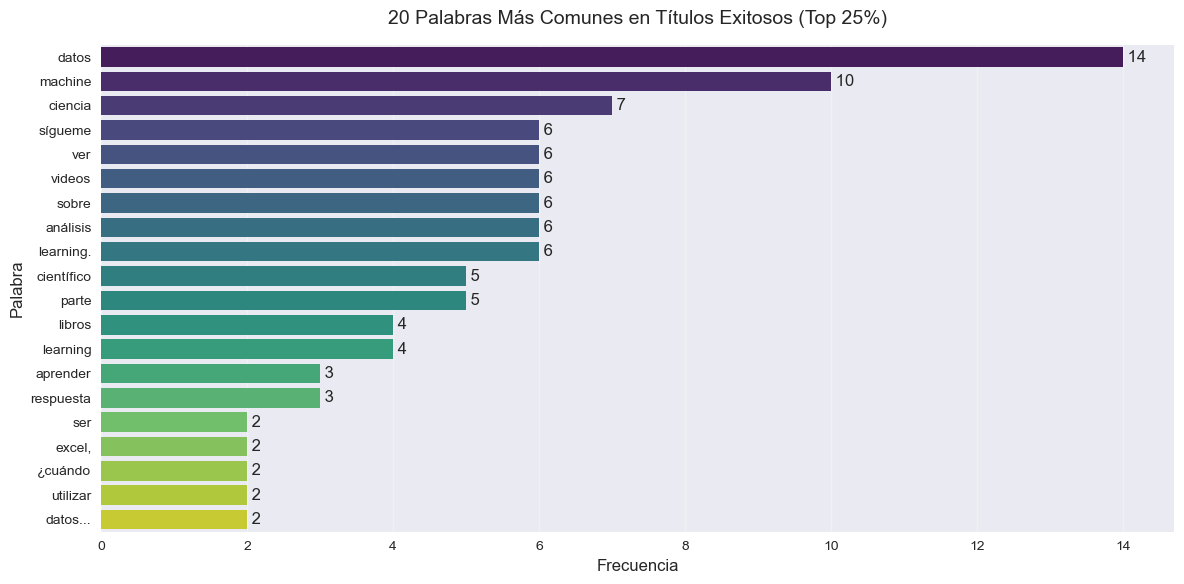

In [33]:

# Gráfico de barras mejorado
plt.figure(figsize=(12, 6))
sns.barplot(x=[count for word, count in common_words], 
            y=[word for word, count in common_words],
            hue=[word for word, count in common_words],  # Asignamos hue para usar la paleta
            palette='viridis',
            dodge=False,  # Evita separación de barras
            legend=False)  # Oculta la leyenda redundante

plt.title('20 Palabras Más Comunes en Títulos Exitosos (Top 25%)', fontsize=14, pad=15)
plt.xlabel('Frecuencia', fontsize=12)
plt.ylabel('Palabra', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Añadir los valores en las barras
for i, (word, count) in enumerate(common_words):
    plt.text(count, i, f' {count}', va='center')

plt.tight_layout()
plt.show()

In [37]:
# Extraer características de los títulos
# Primero llenamos los valores nulos con string vacío
df['TITULO_LIMPIO'] = df['TITULO_LIMPIO'].fillna('')

# Ahora podemos calcular las características
df['LONGITUD_TITULO'] = df['TITULO_LIMPIO'].str.len()
df['NUM_PALABRAS'] = df['TITULO_LIMPIO'].str.split().str.len()

# Análisis de sentimiento
sia = SentimentIntensityAnalyzer()
df['SENTIMIENTO'] = df['TITULO_LIMPIO'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Día de la semana
df['DIA_SEMANA'] = df['FECHA'].dt.dayofweek

# Codificar temas principales (versión más robusta)
temas_principales = {
    'CIENCIA_DATOS': ['ciencia de datos', 'cienciadedatos', 'datascience'],
    'MACHINE_LEARNING': ['machine learning', 'machinelearning', 'ml'],
    'PYTHON': ['python'],
    'SQL': ['sql'],
    'ESTADISTICA': ['estadística', 'estadistica'],
    'LIBROS': ['libros'],
    'TUTORIAL': ['como', 'cuándo', 'debería']
}

for tema, palabras in temas_principales.items():
    # Usamos na=False para manejar valores nulos
    df[tema] = df['TITULO_LIMPIO'].str.contains('|'.join(palabras), case=False, na=False).astype(int)

# Variable objetivo: clasificación de éxito (1 si está en el top 25% de visualizaciones)
threshold = df['VISUALIZACIONES'].quantile(0.75)
df['EXITO'] = (df['VISUALIZACIONES'] >= threshold).astype(int)

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Características para el modelo
features = ['LONGITUD_TITULO', 'NUM_PALABRAS', 'SENTIMIENTO', 'DIA_SEMANA', 'HORA'] + \
           [t.upper() for t in temas_principales.keys()]
X = df[features]
y = df['EXITO']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar modelo
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [43]:

# Evaluar modelo
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6086956521739131

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.93      0.76        15
           1       0.00      0.00      0.00         8

    accuracy                           0.61        23
   macro avg       0.32      0.47      0.38        23
weighted avg       0.42      0.61      0.49        23



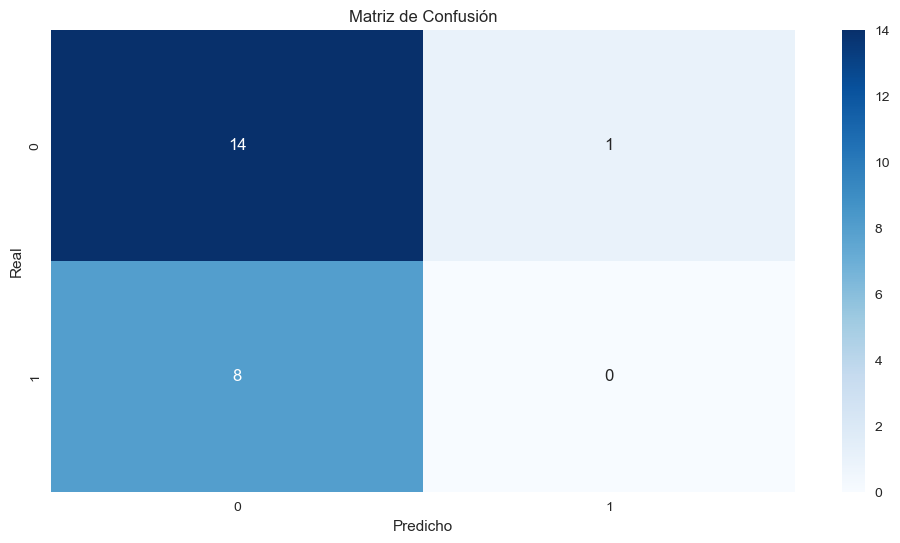

In [45]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

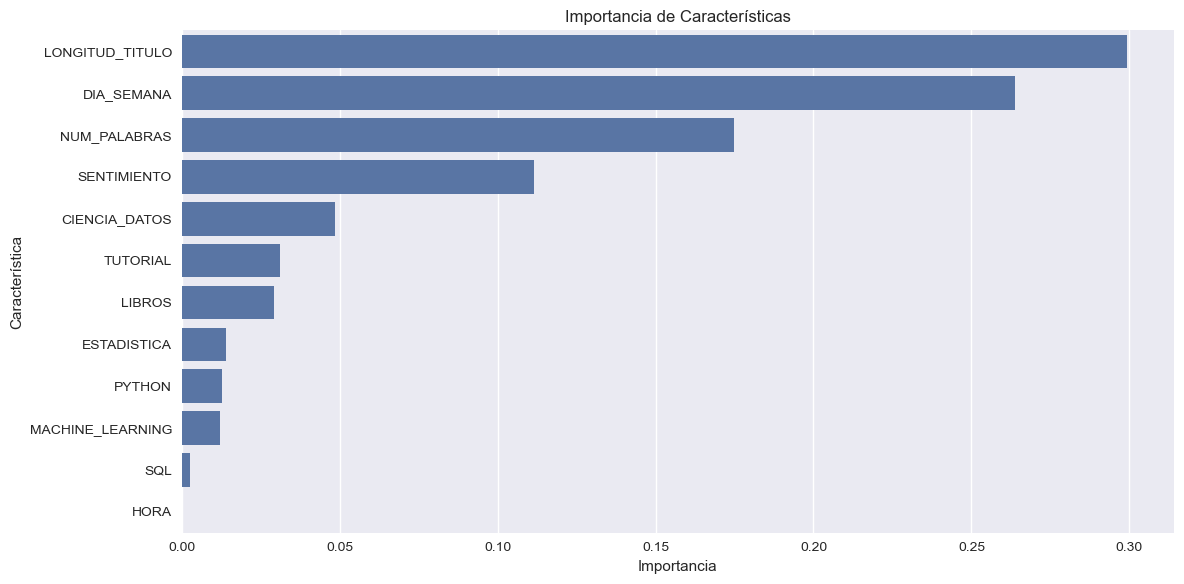

In [47]:
# Importancia de características
feature_imp = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title('Importancia de Características')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

MSE: 1.2588755550332302
R2 Score: 0.08873519524274376


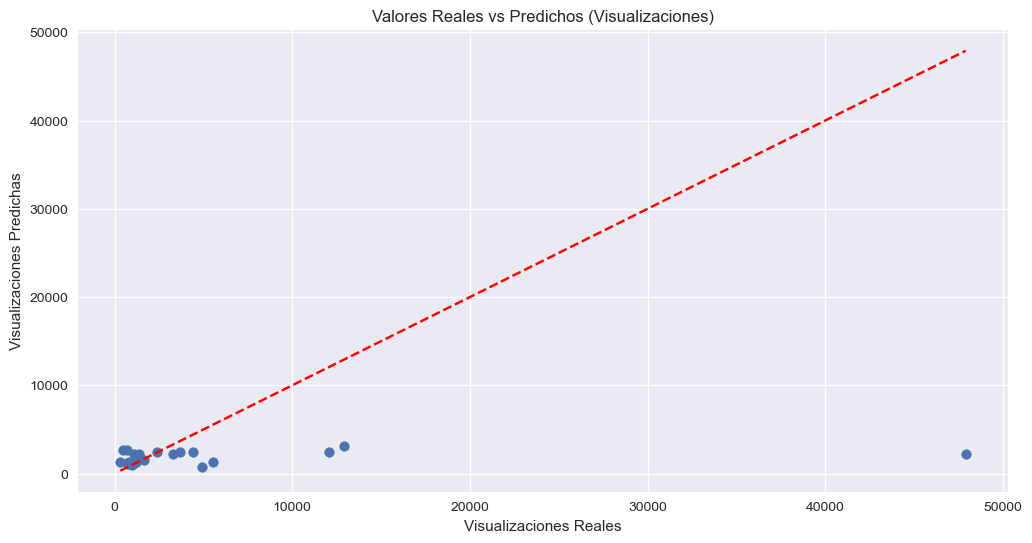

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Usar log de visualizaciones para normalizar
df['LOG_VISUALIZACIONES'] = np.log1p(df['VISUALIZACIONES'])

X = df[features]
y = df['LOG_VISUALIZACIONES']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

# Gráfico de valores reales vs predichos
plt.scatter(np.expm1(y_test), np.expm1(y_pred))
plt.plot([min(np.expm1(y_test)), max(np.expm1(y_test))], 
         [min(np.expm1(y_test)), max(np.expm1(y_test))], 'r--')
plt.title('Valores Reales vs Predichos (Visualizaciones)')
plt.xlabel('Visualizaciones Reales')
plt.ylabel('Visualizaciones Predichas')
plt.show()

GRUPO_VISUALIZACIONES
Medio (1000-10,000)      67
Alto (10,000-100,000)     7
Bajo (0-1000)             0
Name: count, dtype: int64


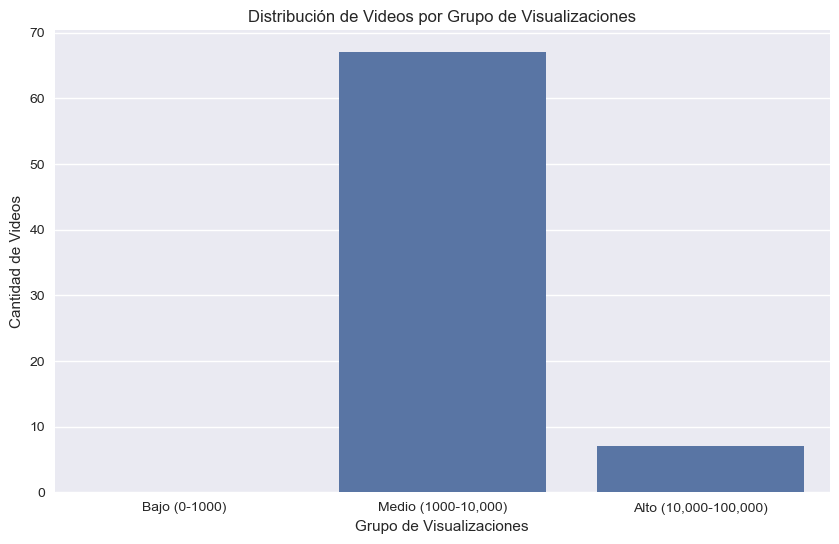

In [53]:
# Definir los grupos
bins = [0, 100, 10000, 100000]
labels = ['Bajo (0-1000)', 'Medio (1000-10,000)', 'Alto (10,000-100,000)']
df['GRUPO_VISUALIZACIONES'] = pd.cut(df['VISUALIZACIONES'], bins=bins, labels=labels, right=False)

# Mostrar distribución
group_counts = df['GRUPO_VISUALIZACIONES'].value_counts()
print(group_counts)

# Visualización
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='GRUPO_VISUALIZACIONES', order=labels)
plt.title('Distribución de Videos por Grupo de Visualizaciones')
plt.xlabel('Grupo de Visualizaciones')
plt.ylabel('Cantidad de Videos')
plt.show()

In [57]:
bajo = df[df['GRUPO_VISUALIZACIONES'] == 'Bajo (0-1000)']
print("Títulos en grupo bajo (0-1000 visualizaciones):")
print(bajo['TITULO_LIMPIO'].value_counts().head(10))

Títulos en grupo bajo (0-1000 visualizaciones):
Series([], Name: count, dtype: int64)


In [59]:
medio = df[df['GRUPO_VISUALIZACIONES'] == 'Medio (1000-10,000)']
print("\nTítulos en grupo medio (100-10,000 visualizaciones):")
print(medio['TITULO_LIMPIO'].value_counts().head(10))


Títulos en grupo medio (100-10,000 visualizaciones):
TITULO_LIMPIO
respuesta a                                                                                                                19
                                                                                                                            4
estadística parte 4 sígueme para ver videos sobre análisis de datos y machine learning.                                     1
libros machine learning y ciencia de datos parte 7 sígueme para ver videos sobre análisis de datos y machine learning.      1
libros machine learning y ciencia de datos parte 8 sígueme para ver videos sobre análisis de datos y machine learning.      1
estadística parte 1 sígueme para ver videos sobre análisis de datos y machine learning.                                     1
libros machine learning y ciencia de datos parte 10 sígueme para ver videos sobre análisis de datos y machine learning.     1
¿cuándo utilizar numpy como científico de datos...

In [61]:
alto = df[df['GRUPO_VISUALIZACIONES'] == 'Alto (10,000-100,000)']
print("\nTítulos en grupo alto (10,000-100,000 visualizaciones):")
print(alto['TITULO_LIMPIO'].value_counts().head(10))


Títulos en grupo alto (10,000-100,000 visualizaciones):
TITULO_LIMPIO
¿como ser científico de datos en 6 meses?                                                                                        1
mejores canales de youtube para aprender ciencia de datos sígueme para ver videos sobre análisis de datos y machine learning.    1
estadística parte 1 sígueme para ver videos sobre análisis de datos y machine learning. mi linkedin es:                          1
news                                                                                                                             1
que debería aprender primero... excel, sql o python?                                                                             1
libros machine learning y ciencia de datos parte 2 sígueme para ver videos sobre análisis de datos y machine learning.           1
respuesta a                                                                                                                      1
Name: count,

In [63]:
# Crear métrica de engagement ponderada
df['ENGAGEMENT'] = (df['ME_GUSTA'] * 0.4 + df['COMENTARIOS'] * 0.3 + 
                    df['COMPARTIDOS'] * 0.2 + df['FAVORITOS'] * 0.1)

# Normalizar por visualizaciones
df['ENGAGEMENT_RATE'] = df['ENGAGEMENT'] / df['VISUALIZACIONES']

# Análisis por grupo
engagement_stats = df.groupby('GRUPO_VISUALIZACIONES')[['ENGAGEMENT', 'ENGAGEMENT_RATE']].mean()
print(engagement_stats)

                       ENGAGEMENT  ENGAGEMENT_RATE
GRUPO_VISUALIZACIONES                             
Bajo (0-1000)                 NaN              NaN
Medio (1000-10,000)     50.432836         0.025784
Alto (10,000-100,000)  862.071429         0.032251


C:\Users\ShePlay\AppData\Local\Temp\ipykernel_4308\2225435118.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  engagement_stats = df.groupby('GRUPO_VISUALIZACIONES')[['ENGAGEMENT', 'ENGAGEMENT_RATE']].mean()


In [65]:
top_bajo = bajo.sort_values('ENGAGEMENT_RATE', ascending=False).head(5)
print("\nTop 5 videos en grupo bajo por engagement rate:")
print(top_bajo[['TITULO_LIMPIO', 'VISUALIZACIONES', 'ENGAGEMENT', 'ENGAGEMENT_RATE']])

KeyError: 'ENGAGEMENT_RATE'

In [67]:
top_medio = medio.sort_values('ENGAGEMENT_RATE', ascending=False).head(5)
print("\nTop 5 videos en grupo medio por engagement rate:")
print(top_medio[['TITULO_LIMPIO', 'VISUALIZACIONES', 'ENGAGEMENT', 'ENGAGEMENT_RATE']])

KeyError: 'ENGAGEMENT_RATE'

In [69]:
top_alto = alto.sort_values('ENGAGEMENT_RATE', ascending=False).head(5)
print("\nTop 5 videos en grupo alto por engagement rate:")
print(top_alto[['TITULO_LIMPIO', 'VISUALIZACIONES', 'ENGAGEMENT', 'ENGAGEMENT_RATE']])

KeyError: 'ENGAGEMENT_RATE'


Análisis de clusters de engagement:
            ME_GUSTA  COMENTARIOS  COMPARTIDOS    FAVORITOS
CLUSTER                                                    
0         171.152778         7.25     9.763889    69.555556
1        3075.000000        46.00   791.000000  2524.000000
2        4138.000000       105.00   508.000000  2436.000000


C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


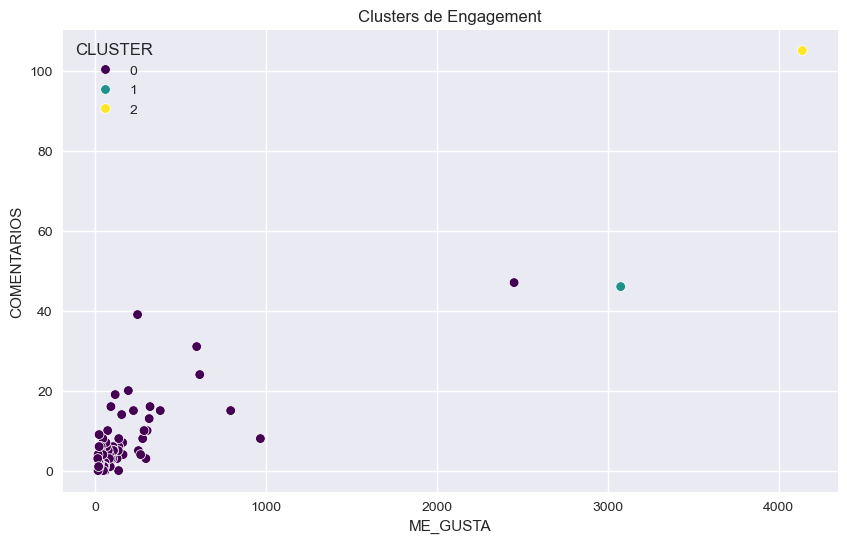

In [71]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Preparar datos para clustering
engagement_data = df[['ME_GUSTA', 'COMENTARIOS', 'COMPARTIDOS', 'FAVORITOS']]
engagement_data = engagement_data[engagement_data['ME_GUSTA'] > 0]  # Eliminar ceros

# Escalar datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(engagement_data)

# Aplicar K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Añadir clusters al dataframe
engagement_data['CLUSTER'] = clusters

# Analizar clusters
cluster_analysis = engagement_data.groupby('CLUSTER').mean()
print("\nAnálisis de clusters de engagement:")
print(cluster_analysis)

# Visualización
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ME_GUSTA', y='COMENTARIOS', hue='CLUSTER', data=engagement_data, palette='viridis')
plt.title('Clusters de Engagement')
plt.show()

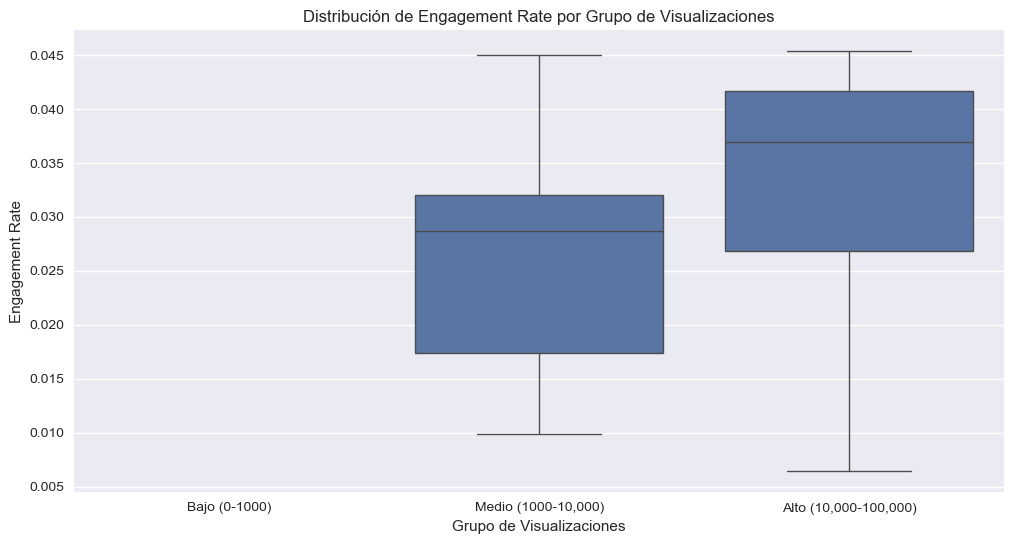

In [75]:
# Gráfico de caja para engagement rate por grupo
plt.figure(figsize=(12, 6))
sns.boxplot(x='GRUPO_VISUALIZACIONES', y='ENGAGEMENT_RATE', data=df, order=labels)
plt.title('Distribución de Engagement Rate por Grupo de Visualizaciones')
plt.xlabel('Grupo de Visualizaciones')
plt.ylabel('Engagement Rate')
plt.show()


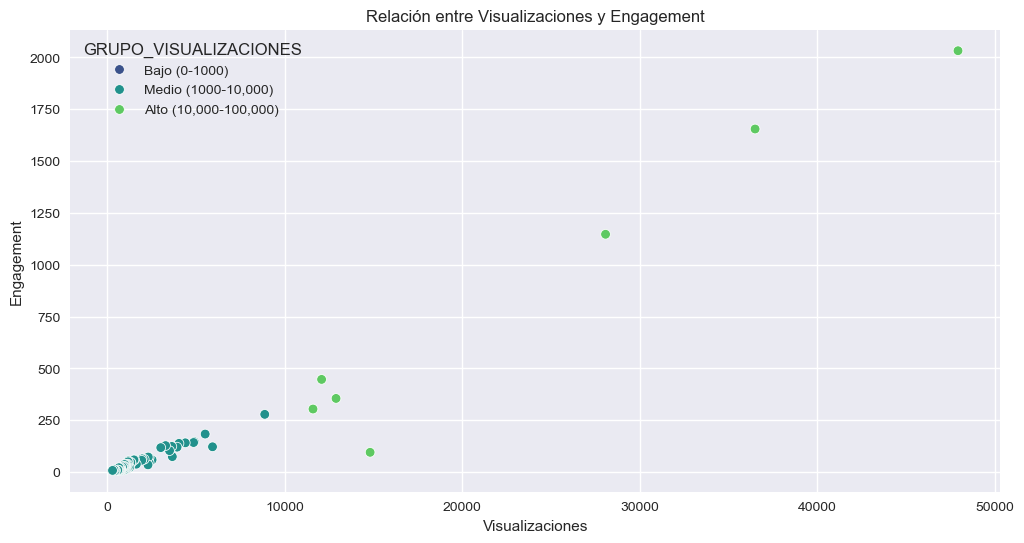

In [77]:

# Gráfico de dispersión: visualizaciones vs engagement
plt.figure(figsize=(12, 6))
sns.scatterplot(x='VISUALIZACIONES', y='ENGAGEMENT', hue='GRUPO_VISUALIZACIONES', data=df, palette='viridis')
plt.title('Relación entre Visualizaciones y Engagement')
plt.xlabel('Visualizaciones')
plt.ylabel('Engagement')
plt.show()


In [87]:
# Wordcloud por grupo
def plot_wordcloud_by_group(group):
    titles = ' '.join(group['TITULO_LIMPIO'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(titles)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Palabras Clave en Grupo {group.name}')
    plt.show()

In [83]:

# Aplicar a cada grupo
for name, group in df.groupby('GRUPO_VISUALIZACIONES'):
    plot_wordcloud_by_group(group)

C:\Users\ShePlay\AppData\Local\Temp\ipykernel_4308\2395309235.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby('GRUPO_VISUALIZACIONES'):


ValueError: We need at least 1 word to plot a word cloud, got 0.